# Project Portfolio: Insurance Policy Propensity Model #

This is a data science portfolio for solving the insurance use case. The dataset used in this project is sourced from the data science competition sponsored by the McKinsey analytics consulting firm.

The competition link can be found here [contest pages] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon-4/)

** Problem Statement: ** an insurance company needs the data scientist's help in building a model to predict the propensity for paying renewal premium and build an incentive plan for its agents to maximize the total net revenue (i.e., incentives provided to collect renewal premiums) from their policyholders (clients).

The insurance propensity dataset comes with information about the policyholders' demographics and aggregated past historical transaction data like # of premiums paid on time, # of premiums paid late, client sourcing channel etc.

In addition to the above information, the insurance company provided the following relationships:
1.	The equation for the effort in hours puts by an agent for incentives provided;
2.	The equation for the expected improvement in renewal probabilities, given the effort from the agent.

** Stakeholders: ** 
* Insurance company senior management
* Insurance company sales agents
* Policyholders

** Goal: ** 
* To predict the propensity of renewal collection
* Create an incentive plan to maximize the net revenues from these policy holders

** Results: ** 
*	96% of accurate predictions were made on a test set of insurance policy renewal data using the Random Forest classifier.
*	Estimated total net revenue is $3.3B USD.

** Risks: ** 
Model incorrectly identified with 4% error rate (Type I error - false positive).

** Mitigation: ** 
Reviewed identified error cases with subject matter experts before any decision making.

** Future Work: ** 
* Model improvements: other ensemble learninig approaches (i.e., stacking, bagging, boosting)
* Feature engineering: try different combinations to generate useful features

** Recommendation for clients: **

## Part A. Data Wrangling ##
A Dataset required data cleansing and metadata formatting. Dataset was loaded onto Python as a data frame. After quick data profiling, I found a couple of problems with a dataset such as missing data and imbalanced classes. In order to the prepared dataset for classification modeling, data cleaning processes were performed. Processes were executed in a following order: feature imputation --> handling outliers --> format metadata types --> feature transformation (i.e., feature encoding). Once dataset was cleaned, data exploration and model building exercises were performed.

In [1]:
# Importing the libraries:
# import all libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import operator
from matplotlib.colors import ListedColormap
from itertools import cycle
from sklearn.preprocessing import Imputer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
from scipy import interp
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import sklearn.base as skb
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm

# Read insurance training set:
df = pd.read_csv('insurance_train.csv')
# Standardize column names by making lowercase: 
df.columns = map(str.lower, df.columns)
# Print dataframe head: 5 rows;
df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,income,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


### Check # of missing value counts and percentage ###

In [2]:
# Drop meaningless feature: 'id'
#df = df.drop(['id'], axis=1)
# Check number of missing values and datatypes in dataframe:
df.info()
# Compute missing value stat.: pre-data cleansing
df_missing = df.isnull().sum()   
# Create missing value dataframe:
df_missing = pd.DataFrame(df_missing)
# Rename column as count:
df_missing.columns = ['count']
# Compute missing value %:
df_missing['pct'] = (df_missing['count']/len(df)) * 100

# sort values by missing percent(%):
df_missing.sort_values(by='pct', ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
income                              79853 non-null int64
count_3-6_months_late               79756 non-null float64
count_6-12_months_late              79756 non-null float64
count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(6), object(2)
memory usage: 7.9+ MB


,count,pct
application_underwriting_score,2974,3.724343
count_3-6_months_late,97,0.121473
count_6-12_months_late,97,0.121473
count_more_than_12_months_late,97,0.121473
id,0,0.000000
perc_premium_paid_by_cash_credit,0,0.000000
age_in_days,0,0.000000
income,0,0.000000
no_of_premiums_paid,0,0.000000
sourcing_channel,0,0.000000


Based on the missing value % computation, there were no features with a missing value greater than 50% were found. Now, we can directly proceed to the missing value replacement on these features. "Application underwriting score" was a feature with the highest missing value % (i.e., 3.72%).

### Feature Engineering: age in days to age in years ###
Convert age_in_days to age_in_years, usually age is reported as years.

In [3]:
# Create a new feature: age converted in years
df['age_in_years'] = round(df['age_in_days']/365, 0)

# Drop age_in_days from dataframe:
df = df.drop(['age_in_days'], axis=1)

# Reorder columns by appropriate order:
df = df[['id','perc_premium_paid_by_cash_credit','age_in_years',
        'income','count_3-6_months_late','count_6-12_months_late',
        'count_more_than_12_months_late','application_underwriting_score',
        'no_of_premiums_paid','sourcing_channel','residence_area_type',
        'premium','renewal']]

### Compute Summary Statistics: pre-data cleansing ###
Compute summary statistics and report on numerical features only!

In [4]:
# Compute summary stat.: pre-data cleansing #
###############################################################################
# Note: NO stats computed for categorical variables (nominal & ordinal features)
df_stat_pre = df.describe().T

# Drop output label: 'renewal'
df_stat_pre = df_stat_pre.drop(['id','renewal'], axis=0)

# Reorder columns in following order: count to std
df_stat_pre = df_stat_pre[['count','min','max','mean','std','25%','50%','75%']]

# Print summary stat:
df_stat_pre

,count,min,max,mean,std,25%,50%,75%
perc_premium_paid_by_cash_credit,79853.0,0.0,1.00,0.314288,0.334915,0.034,0.167,0.538
age_in_years,79853.0,21.0,103.00,51.607404,14.270484,41.000,51.000,62.000
income,79853.0,24030.0,90262600.00,208847.171177,496582.597257,108010.000,166560.000,252090.000
count_3-6_months_late,79756.0,0.0,13.00,0.248671,0.691468,0.000,0.000,0.000
count_6-12_months_late,79756.0,0.0,17.00,0.078188,0.436507,0.000,0.000,0.000
count_more_than_12_months_late,79756.0,0.0,11.00,0.060008,0.312023,0.000,0.000,0.000
application_underwriting_score,76879.0,91.9,99.89,99.067291,0.739799,98.810,99.210,99.540
no_of_premiums_paid,79853.0,2.0,60.00,10.863887,5.170687,7.000,10.000,14.000
premium,79853.0,1200.0,60000.00,10924.507533,9401.676542,5400.000,7500.000,13800.000


### Data Splits & Feature Transformation ###
First, the dataset was split into a set of input features and an output label (i.e., renewal). Secondly, feature imputation was performed to replace any missing values on different data types (i.e., numerical and ordinal features). For example, "feature 1" and "feature 2" were replaced by median and mode. Finally, a metadata formatting was applied to ensure each feature for having a correct data type.

In [5]:
###########################
# Feature Imputation:
###########################
# Write a function: to create counts dataframe by descending order
def df_counts(x):
    df_counts = df[x].value_counts().sort_values(ascending=False)
    df_counts = pd.DataFrame(df_counts)
    df_counts.columns = ['counts']
    return df_counts

# feature 1: count_3-6_months_late
###############################################################################
df_counts_3_6_months = df_counts('count_3-6_months_late')
print(df_counts_3_6_months.iloc[0])

# feature 2: count_6-12_months_late
###############################################################################
df_counts_6_12_months = df_counts('count_6-12_months_late')
print(df_counts_6_12_months.iloc[0])

# feature 3: count_more_than_12_months_late
###############################################################################
df_counts_more_than_12_months = df_counts('count_more_than_12_months_late')
print(df_counts_more_than_12_months.iloc[0])
    
# Write a function to fill missing value using fillna
def df_fillna(x,y):
    df_fillna = df[x].fillna(y)
    return df_fillna

# Replace missing values via mode: indexes from 4-6;
df['count_3-6_months_late'] = df_fillna('count_3-6_months_late',0)
df['count_6-12_months_late'] = df_fillna('count_6-12_months_late',0)
df['count_more_than_12_months_late'] = df_fillna('count_more_than_12_months_late',0)

counts    66801
Name: 0.0, dtype: int64
counts    75831
Name: 0.0, dtype: int64
counts    76038
Name: 0.0, dtype: int64


**Summary: Replacement via mode on ordinal feature**

Here, any ordinal features (i.e., counts) were replaced by the mode. As you can see, most clients never had a payment late (i.e., 0 times).

In [6]:
# Specify inputs and output label:
X, y = df.iloc[:,:-1], df['renewal']

# Feature Imputation #
###############################################################################
# Imputation: application_under_writing_score by median
# Column index = 7, fit(input.iloc[:, n:n+1])
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis=0)
imputer = imputer.fit(X.iloc[:,7:8])
X.iloc[:,7:8] = imputer.transform(X.iloc[:,7:8])

**Summary: Replacement via mean on numerical feature**

Here, an application underwriting score was replaced by the mean because it is a numerical feature.

In [7]:
# Prepare cleansed dataframe:
# Concatenated cleaned inputs and response variable as a new df:
df_cleaned = pd.concat([X,y], axis=1)

# Check any missing values on a new dataframe:
print(df_cleaned.isnull().sum())

# Convert data types for cleaned dataframe:
df_cleaned['sourcing_channel'] = df_cleaned['sourcing_channel'].astype('category')
df_cleaned['residence_area_type'] = df_cleaned['residence_area_type'].astype('category')

# Check data type:
df_cleaned.info()

# Save cleaned dataframe:
#df_cleaned.to_csv('IP_train_cleaned.csv')

id                                  0
perc_premium_paid_by_cash_credit    0
age_in_years                        0
income                              0
count_3-6_months_late               0
count_6-12_months_late              0
count_more_than_12_months_late      0
application_underwriting_score      0
no_of_premiums_paid                 0
sourcing_channel                    0
residence_area_type                 0
premium                             0
renewal                             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_years                        79853 non-null float64
income                              79853 non-null int64
count_3-6_months_late               79853 non-null float64
count_6-12_months_late              79853 non-null float64
count_more_than_12_months_late    

## Part B. Exploratory Data Analysis ##

### EDA: cleaned training set ###
Data exploration was conducted on the cleaned train set. At this phase, we are interested in exploring any interesting relationships among features and identify which feature has a clear impact on predicting non-renewal clients over renewed clients. 

Here is a list of sample questions that I asked myself:
1. When low-value clients are identified, how should we treat them?
2. What is the demographic profile of low-value clients?
3. What is the best clients' renewal application sourcing channel?
4. Do clients pay premiums on time?
5. What % of clients make premium paid by cash or credit?

Insurance company marketing strategies:
* Understand who and why clients get churned? In other words, no application renewal.
* How can we plan for new insurance policies based on specific client groups? (i.e., mid-30-40s with high monthly income)
* How can we retain 'loyal clients' who paid premiums on time for every single payment with less % of cash/credit card usage?

In [8]:
# Copy dataframe for EDA exercise:
df_EDA = df_cleaned.copy()
# Check drop duplicates: drop '0' rows
df_EDA = df_EDA.drop_duplicates()
# Format: % premium paid by cash/credit multiply by 100
df_EDA['perc_premium_paid_by_cash_credit'] = df_EDA['perc_premium_paid_by_cash_credit'] * 100 

In [9]:
###############################################################################
# Part B: Exploratory Data Analysis #
###############################################################################
# Compute summary stat.: post-data cleansing 
IP_summary_post = df_EDA.describe().T

# Reorder columns order in summary dataframe
IP_summary_post = IP_summary_post[['count','min','max','mean','std','25%','50%','75%']]

# drop non-numerical and meaningless features
IP_summary_post = IP_summary_post.drop(['id','renewal'], axis=0)
IP_summary_post

,count,min,max,mean,std,25%,50%,75%
perc_premium_paid_by_cash_credit,79853.0,0.0,100.00,31.428774,33.491457,3.40,16.70,53.80
age_in_years,79853.0,21.0,103.00,51.607404,14.270484,41.00,51.00,62.00
income,79853.0,24030.0,90262600.00,208847.171177,496582.597257,108010.00,166560.00,252090.00
count_3-6_months_late,79853.0,0.0,13.00,0.248369,0.691102,0.00,0.00,0.00
count_6-12_months_late,79853.0,0.0,17.00,0.078093,0.436251,0.00,0.00,0.00
count_more_than_12_months_late,79853.0,0.0,11.00,0.059935,0.311840,0.00,0.00,0.00
application_underwriting_score,79853.0,91.9,99.89,99.072606,0.726395,98.83,99.21,99.52
no_of_premiums_paid,79853.0,2.0,60.00,10.863887,5.170687,7.00,10.00,14.00
premium,79853.0,1200.0,60000.00,10924.507533,9401.676542,5400.00,7500.00,13800.00


### Feature Engineering: age_in_years, counts_months_late, no_premiums_paid ###
Feature engineering is a process in which we use existing features to generate new useful features. In this dataset, we had a few key numerical features that we can apply some discretization technique for producing a range of group features. For example, an age group is a numerical feature that can help us to further analyze the difference between renewed vs not renewed clients. Also, other numerical features such as # of premiums paid on time, # of late premium payments can be grouped into a certain range of groups as well.

In [10]:
# Stratification #
# Define bins for ordinal features:
age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 103]
count_mo1_bins = [-0.01, 2, 4, 6, 8, 10, 12]
count_mo2_bins = [-0.01, 2, 4, 6, 8, 10, 12, 14]
count_mo3_bins = [-0.01, 2, 4, 6, 8, 10, 12, 14, 16, 18]
no_premiums_paid_bins = [0, 10, 20, 30, 40, 50, 60]
premium_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000] 
income_bins = [20000, 45000, 70000, 95000, 110000, 135000, 160000, 185000, 210000, 235000, 260000, 285000, 90300000]

# Generate new ordinal group features based on binning:
df_EDA['age_group'] = pd.cut(np.array(df_EDA['age_in_years']), bins=age_bins)
df_EDA['count_3-6_mo_group'] = pd.cut(np.array(df_EDA['count_3-6_months_late']), bins=count_mo2_bins)
df_EDA['count_6-12_mo_group'] = pd.cut(np.array(df_EDA['count_6-12_months_late']), bins=count_mo3_bins)
df_EDA['count_more_than_12_mo_group'] = pd.cut(np.array(df_EDA['count_more_than_12_months_late']), bins=count_mo1_bins)
df_EDA['no_premiums_paid_group'] = pd.cut(np.array(df_EDA['no_of_premiums_paid']), bins=no_premiums_paid_bins)
# Generate new numerical group features based on binning:
df_EDA['premium_group'] = pd.cut(np.array(df_EDA['premium']), bins=premium_bins)
df_EDA['income_group'] = pd.cut(np.array(df_EDA['income']), bins=income_bins)

# Check newly generated features:
print(df_EDA['age_group'].head())
print(df_EDA['count_6-12_mo_group'].tail())
print(df_EDA['no_premiums_paid_group'].head())
print(df_EDA['premium_group'].head())
print(df_EDA['income_group'].head())

0    (30, 40]
1    (50, 60]
2    (40, 50]
3    (40, 50]
4    (80, 90]
Name: age_group, dtype: category
Categories (8, interval[int64]): [(20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80] < (80, 90] < (90, 103]]
79848    (-0.01, 2.0]
79849    (-0.01, 2.0]
79850    (-0.01, 2.0]
79851    (-0.01, 2.0]
79852    (-0.01, 2.0]
Name: count_6-12_mo_group, dtype: category
Categories (9, interval[float64]): [(-0.01, 2.0] < (2.0, 4.0] < (4.0, 6.0] < (6.0, 8.0] ... (10.0, 12.0] < (12.0, 14.0] < (14.0, 16.0] < (16.0, 18.0]]
0    (10, 20]
1    (20, 30]
2     (0, 10]
3     (0, 10]
4    (10, 20]
Name: no_premiums_paid_group, dtype: category
Categories (6, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60]]
0        (0, 10000]
1    (10000, 20000]
2        (0, 10000]
3        (0, 10000]
4        (0, 10000]
Name: premium_group, dtype: category
Categories (6, interval[int64]): [(0, 10000] < (10000, 20000] < (20000, 30000] < (30000, 40000] < (40000, 50000] < (5000

### Correlation Matrix: Entire Client Population ###

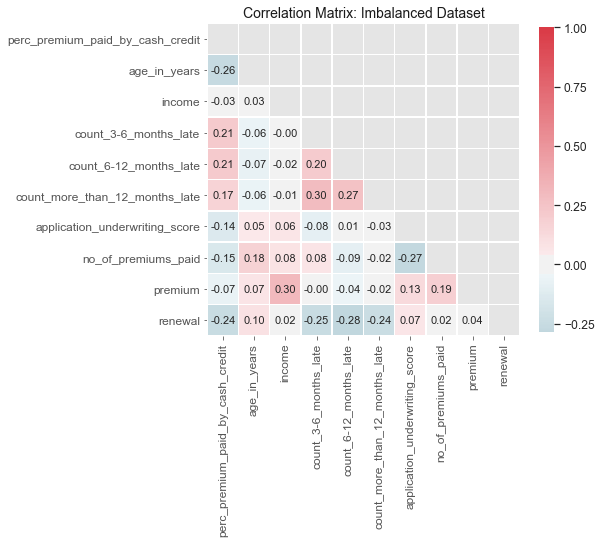

In [11]:
# Correlation Matrix Plot # entire dataset
###############################################################################
# List numerical column names only:
cols =['perc_premium_paid_by_cash_credit', 'age_in_years', 'income',
       'count_3-6_months_late', 'count_6-12_months_late',
       'count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'premium', 'renewal']

# Create a correlation matrix:
cm = df_EDA[cols].corr()

# Create a mask to filter correlation matrix: diagonally
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix heatmap
f,ax = plt.subplots(figsize=(7,7))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.set(font_scale=1.1)
sns.heatmap(cm, mask=mask, cmap=cmap, fmt='.2f', center=0,
           annot=True, square=True, linewidth=.5,
           annot_kws={'size':11}, cbar_kws={'shrink':.8})
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Matrix: Imbalanced Dataset', fontsize=14)
plt.show()

**Summary: correlation matrix - imbalanced dataset**

Here is a quick summary on the correlation between features and a renewal status. The strongest negative correlation was found between count 6-12 months late vs. renewal (**r = -0.28**). In contrast, the strongest positive correlation was found between age vs. renewal (**r = 0.10**).

In [12]:
# Filter correlations between feature by threshold: r> 0.10
for x in cm.columns:
    for y in cm.columns:
        if x<y and cm[x][y] >abs(0.10):
            print(x,y,cm[x][y])

age_in_years no_of_premiums_paid 0.176544266449
income premium 0.302825176913
count_3-6_months_late perc_premium_paid_by_cash_credit 0.213010532871
count_3-6_months_late count_6-12_months_late 0.204286376083
count_3-6_months_late count_more_than_12_months_late 0.296138849917
count_6-12_months_late perc_premium_paid_by_cash_credit 0.213952692182
count_6-12_months_late count_more_than_12_months_late 0.266336778558
count_more_than_12_months_late perc_premium_paid_by_cash_credit 0.167213117277
application_underwriting_score premium 0.131042253767
no_of_premiums_paid premium 0.191888816824


### Pie Chart: insurance clients by renewal status ###

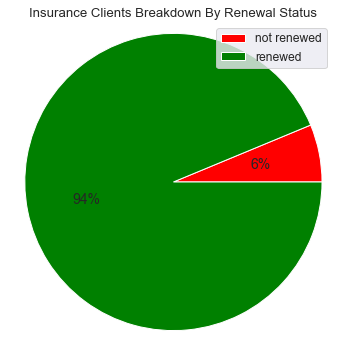

In [13]:
# Count frequencies and shows breakdown by renewal label:
def grp_df_label(x):
    df_grp = pd.DataFrame(df_EDA.groupby(x)[x].count())
    df_grp.columns = ['count']
    return df_grp

# Grouped dataframe by renewal:
df_grp_renewal = grp_df_label('renewal')

# Write a function to plot pie chart:
def pie_plot(x,y,c):
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.pie(x, colors = c, autopct='%.0f%%', startangle=0,
           wedgeprops = {'edgecolor':'white'}, textprops={'fontsize':14})
    plt.legend(labels = y, loc='upper right')
    plt.axis('equal')
    plt.tight_layout()
    
# Plot a pie chart insurance clients breakdown by renewal status:
pie_plot(df_grp_renewal, ['not renewed', 'renewed'], ['red','green'])
plt.title('Insurance Clients Breakdown By Renewal Status')
plt.show()

**Summary**: 
1. The pie plot showed us that about 6% of insurance policies were not renewed. 
2. This confirmed us that the dataset is highly imbalanced classification problem for building a propensity model.

### Function: grouped dataframe by renewal status and demographic factors ###
A function to make grouped data frame based on a renewal status and each factor for counting frequencies.

In [14]:
# Write a function: grouped dataframe by renewal satus and factors;
def grp_df(x,y):
    df_grp = pd.DataFrame(df_EDA.groupby([y,x])[x].count())
    df_grp.columns = ['counts']
    return df_grp

# Count frequencies by categorical factors:
df_grp_sourcing = grp_df('sourcing_channel','renewal')
df_grp_residence = grp_df('residence_area_type','renewal')

# Count frequencies by demographic factors:
df_grp_cnt_3_6_mo_group = grp_df('count_3-6_mo_group','renewal')
df_grp_cnt_6_12_mo_group = grp_df('count_6-12_mo_group','renewal')
df_grp_cnt_more_than_12_mo_group = grp_df('count_more_than_12_mo_group','renewal')
df_grp_age_group = grp_df('age_group','renewal')
df_grp_no_premiums_paid_group = grp_df('no_premiums_paid_group','renewal')
df_grp_premium_group = grp_df('premium_group','renewal')
df_grp_income_group = grp_df('income_group','renewal')

### Functions: split dataframes by renewal status, pie chart subplots ###
A function to split a grouped counts dataframe by a renewal status (i.e., renewed and not renewed.)

In [15]:
# Write a function: split dataframes into two labels:
def df_split(x):
    df_grp_0 = x.loc[0]
    df_grp_1 = x.loc[1]
    return(df_grp_0, df_grp_1)

# Write a function: plot a pie chart with two subplots
def pie_subplots(df1,df2,y,var,c):
    f,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.0)
    # Subplot 1: non-renewed clients
    ax1.pie(df1, colors=c, autopct='%.0f%%', startangle=0, 
        wedgeprops = {'edgecolor':'white'}, textprops = {'fontsize':14})
    ax1.legend(labels=y, loc='upper right', fontsize=10)
    ax1.set_title('Clients not renewed by '+var, fontsize=13)

    # Subplot 2: renewed clients
    ax2.pie(df2, colors=c, autopct='%.0f%%', startangle=0, 
        wedgeprops = {'edgecolor':'white'}, textprops = {'fontsize':14})
    ax2.legend(labels=y, loc='upper right', fontsize=10)
    ax2.set_title('Clients renewed by '+var, fontsize=13)
    plt.show()

### Uni-variate Analyses: Pie Chart ### 
A function to plot pie charts based on a renewal status and categorical factors.

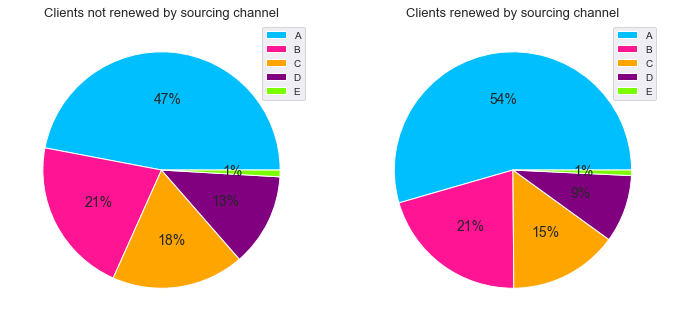

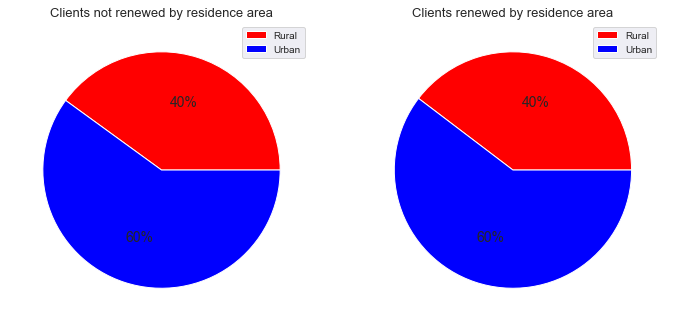

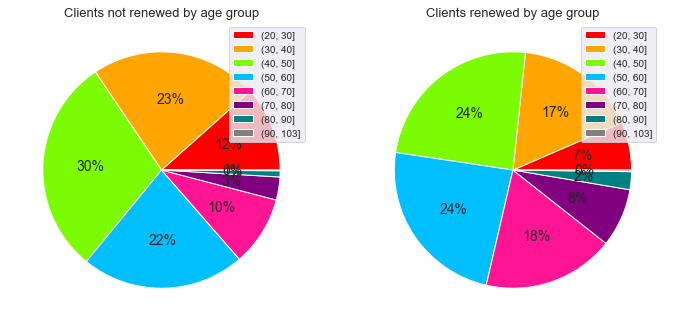

In [16]:
# Split dataframe by sourcing_channel
df_grp_sourcing_0, df_grp_sourcing_1 = df_split(df_grp_sourcing)
# Split dataframe by residence_area_type
df_grp_residence_0, df_grp_residence_1 = df_split(df_grp_residence)
# Split dataframe grouped by age_groups
df_grp_age_group_0, df_grp_age_group_1 = df_split(df_grp_age_group) 

plt.figure()
# Plot a pie chart: sourcing_channel
pie_subplots(df_grp_sourcing_0, df_grp_sourcing_1, df_grp_sourcing_0.index,
            'sourcing channel', ['deepskyblue','deeppink','orange',
                                'purple','lawngreen'])
plt.show()

# Plot a pie chart: residence_area_type
pie_subplots(df_grp_residence_0, df_grp_residence_1, df_grp_residence_0.index,
            'residence area', ['red','blue'])
plt.show()

# Plot a pie chart: 
pie_subplots(df_grp_age_group_0, df_grp_age_group_1, df_grp_age_group_0.index,
            'age group', ['red','orange','lawngreen','deepskyblue','deeppink','purple','teal','gray'])
plt.show()

**Summary: pie charts by sourcing channel, residential area and age groups**

Here is a quick summary of each pie chart group:
* Sourcing channel: A, B, and C were the most popular sourcing channels for renewed and not renewed policyholders.
* Residential area: In terms of the client population, 40% of them were rural and 60% of them were urban residents.
* Age groups: the most significant age groups that composed most of the client population were from age in 30-40 to 50-60 groups.

### Split grouped dataframes by renewal status ###

In [17]:
# Split grouped dataframes by renewal status:
df_grp_cnt_3_6_mo_group_0, df_grp_cnt_3_6_mo_group_1 = df_split(df_grp_cnt_3_6_mo_group) 
df_grp_cnt_6_12_mo_group_0, df_grp_cnt_6_12_mo_group_1 = df_split(df_grp_cnt_6_12_mo_group) 
df_grp_cnt_more_than_12_mo_group_0, df_grp_cnt_more_than_12_mo_group_1 = df_split(df_grp_cnt_more_than_12_mo_group) 
df_grp_no_premiums_paid_group_0, df_grp_no_premiums_paid_group_1 = df_split(df_grp_no_premiums_paid_group) 

df_grp_premium_group_0, df_grp_premium_group_1 = df_split(df_grp_premium_group) 
df_grp_income_group_0, df_grp_income_group_1 = df_split(df_grp_income_group) 

### Function: merge two different clients groups into one dataframe ###

In [18]:
# Write a function: bind two client groups into by merging (left join)
def merge_df_grp(df1,df2):
    df_grp_merge = pd.merge(df1, df2, how='left', left_index=True, right_index=True)
    df_grp_merge.columns = ['not renewed', 'renewed'] 
    df_grp_merge = df_grp_merge.fillna(0)
    return df_grp_merge

### Function: plot a bar chart with two subplots ###

In [19]:
# Write a function: plot a bar chart with two subplots (grouped dataframe)
def bar_subplots(df1,df2,var1,var2):
    f,(ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))
    plt.subplots_adjust(hspace=0.5, wspace=1.5)
    plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.0)
    # Subplot 1: feature 1
    df1.plot(kind='bar', color=['red','deepskyblue'], ax=ax1)
    ax1.legend(loc='upper right')
    ax1.set_title('Frequency bar chart by '+var1, fontsize=14)
    ax1.set_xlabel('Counts by '+var1,fontsize=12)
    ax1.set_ylabel('Number of clients',fontsize=12)
    ax1.grid(False)
    # Subplot 2: feature 2
    df2.plot(kind='bar', color=['red','deepskyblue'], ax=ax2)
    ax2.legend(loc='upper right')
    ax2.set_title('Frequency bar chart by '+var2, fontsize=14)
    ax2.set_xlabel('Counts by '+var2,fontsize=12)
    ax2.set_ylabel('Number of clients',fontsize=12)
    ax2.grid(False)

### Uni-variate Analyses: Bar Chart ### 
**Based on client renewal status and numerical factors**

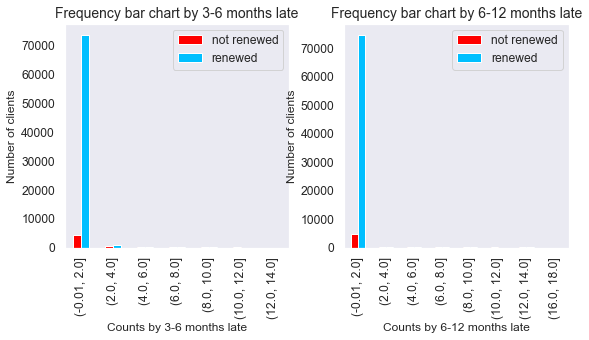

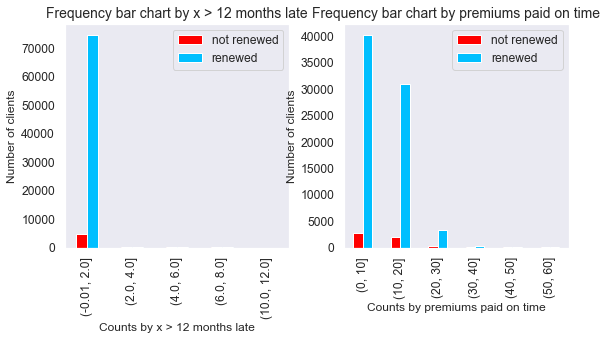

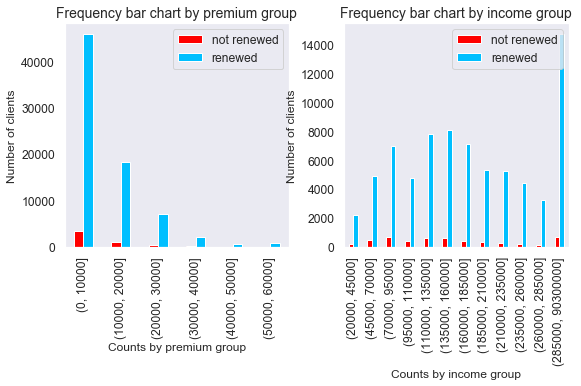

In [20]:
# Merge grouped dataframes for two client groups:
df_grp_merge_3_6_mo = merge_df_grp(df_grp_cnt_3_6_mo_group_0, df_grp_cnt_3_6_mo_group_1)
df_grp_merge_6_12_mo = merge_df_grp(df_grp_cnt_6_12_mo_group_0, df_grp_cnt_6_12_mo_group_1)
df_grp_cnt_more_than_12_mo = merge_df_grp(df_grp_cnt_more_than_12_mo_group_0, df_grp_cnt_more_than_12_mo_group_1)
df_grp_no_premiums_paid = merge_df_grp(df_grp_no_premiums_paid_group_0, df_grp_no_premiums_paid_group_1)
df_grp_income = merge_df_grp(df_grp_income_group_0, df_grp_income_group_1)
df_grp_premium = merge_df_grp(df_grp_premium_group_0, df_grp_premium_group_1)

plt.figure()
# Plot bar charts: counts 3 to 6 months late, 6 to 12 months late
bar_subplots(df_grp_merge_3_6_mo,df_grp_merge_6_12_mo,
            '3-6 months late','6-12 months late')
plt.show()

plt.figure()
# Plot bar charts: counts more than 12 months late,  # of premiums paid on time
bar_subplots(df_grp_cnt_more_than_12_mo,df_grp_no_premiums_paid,
            'x > 12 months late','premiums paid on time')
plt.show()

plt.figure()
# Plot bar charts: $ premium amount, $ income amount
bar_subplots(df_grp_premium,df_grp_income,
            'premium group','income group')
plt.show()

**Summary: bar charts by premiums paid group, premium group and income group**

Here is a quick summary on bar charts:
* no. of premiums paid late group: most of the renewed client population had 0 to 2 times delay in their premium payments.
* no. of premiums paid group: most of the renewed client population paid their premiums on time from 0 to 20 payments.
* premium group: many clients had their policy premium amount less than 10K USD.
* income group: the highest proportion of clients had their income range over 285K USD.

### Split a dataframe by renewal status: detail analysis ###

In [21]:
# Split a dataframe by class label:
df_renewal_0 = df_EDA[df_EDA['renewal'] == 0] 
df_renewal_1 = df_EDA[df_EDA['renewal'] == 1]

### Compute Summary Statistics: non-renewal clients population ###

In [22]:
# EDA: non-renewal clients population #
# Compute summary stat.: post-data cleansing 
IP_non_renew = df_renewal_0.describe().T

# Reorder columns order in summary dataframe
IP_non_renew = IP_non_renew[['count','min','max','mean','std','25%','50%','75%']]

# Drop non-numerical and meaningless features
IP_non_renew = IP_non_renew.drop(['id','renewal'], axis=0)
IP_non_renew

,count,min,max,mean,std,25%,50%,75%
perc_premium_paid_by_cash_credit,4998.0,0.00,100.00,62.662585,35.236901,31.70,72.80,97.10
age_in_years,4998.0,21.00,101.00,46.355342,12.766047,37.00,46.00,54.00
income,4998.0,24030.00,7500070.00,177058.799520,207754.301594,90102.50,138100.00,210725.00
count_3-6_months_late,4998.0,0.00,13.00,0.907563,1.333464,0.00,0.00,1.00
count_6-12_months_late,4998.0,0.00,17.00,0.557623,1.146547,0.00,0.00,1.00
count_more_than_12_months_late,4998.0,0.00,11.00,0.347739,0.763070,0.00,0.00,0.00
application_underwriting_score,4998.0,92.24,99.89,98.883852,0.862564,98.56,99.08,99.46
no_of_premiums_paid,4998.0,2.00,59.00,10.410364,5.784630,6.00,10.00,14.00
premium,4998.0,1200.00,60000.00,9599.519808,8610.731129,5400.00,7500.00,11700.00


### Compute Summary Statistics: renewal clients population ###

In [23]:
# EDA: renewal clients population #
# Compute summary stat.: post-data cleansing 
IP_renew = df_renewal_1.describe().T

# Reorder columns order in summary dataframe
IP_renew = IP_renew[['count','min','max','mean','std','25%','50%','75%']]

# Drop non-numerical and meaningless features
IP_renew = IP_renew.drop(['id','renewal'], axis=0)
IP_renew

,count,min,max,mean,std,25%,50%,75%
perc_premium_paid_by_cash_credit,74855.0,0.0,100.00,29.343321,32.314049,3.10,14.80,48.70
age_in_years,74855.0,21.0,103.00,51.958079,14.296852,41.00,51.00,62.00
income,74855.0,24030.0,90262600.00,210969.651727,510005.936457,109130.00,168870.00,255050.00
count_3-6_months_late,74855.0,0.0,9.00,0.204355,0.599884,0.00,0.00,0.00
count_6-12_months_late,74855.0,0.0,15.00,0.046076,0.314463,0.00,0.00,0.00
count_more_than_12_months_late,74855.0,0.0,8.00,0.040719,0.242830,0.00,0.00,0.00
application_underwriting_score,74855.0,91.9,99.89,99.085209,0.714615,98.85,99.21,99.53
no_of_premiums_paid,74855.0,2.0,60.00,10.894169,5.125691,7.00,10.00,14.00
premium,74855.0,1200.0,60000.00,11012.975753,9445.566438,5400.00,7500.00,13800.00


### Uni-variate Analyses: Histogram ### 
**By renewal status on numerical features**

For continuous measure analysis, a set of five histograms were plotted for checking distributions on each feature. Here is a list of five features that I selected: income, premium, underwriting score, age, and % premium paid by cash or credit. Also, for each feature, a pair of distributions were plotted for non-renewal and renewal client population.

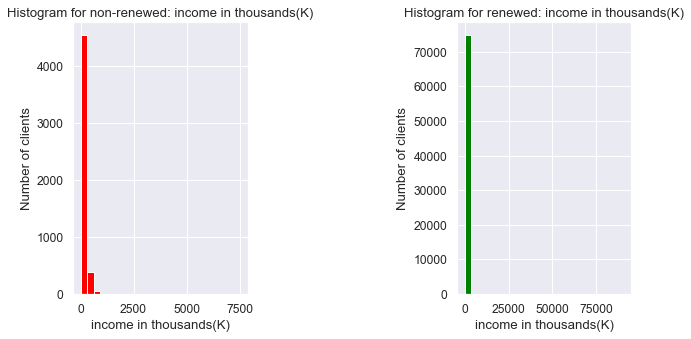

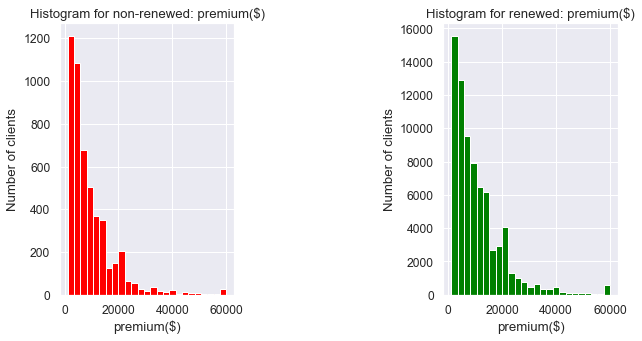

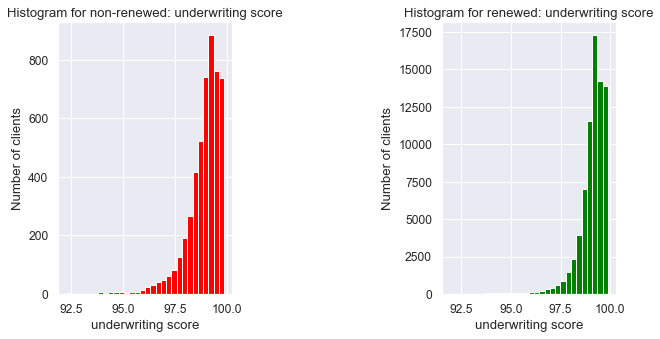

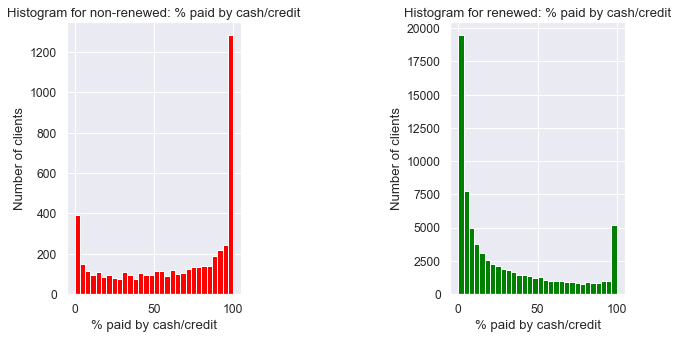

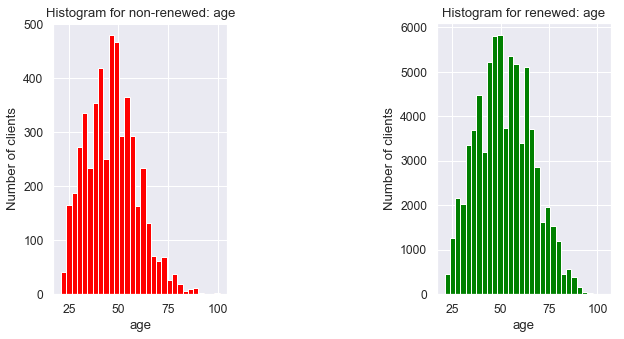

In [24]:
# Write a function: plot a histogram with two subplots
def plot_hist(x,n,bins,var):
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    plt.subplots_adjust(hspace=0.5, wspace=1.2)
    # Subplot 1: non-renewal
    ax1.hist(df_renewal_0[x]/n, bins=bins, color='red')
    ax1.set_xlabel(var)
    ax1.set_ylabel('Number of clients')
    ax1.set_title('Histogram for non-renewed: '+var)
    # Subplot 2: non-renewal
    ax2.hist(df_renewal_1[x]/n, bins=bins, color='green')
    ax2.set_xlabel(var)
    ax2.set_ylabel('Number of clients')
    ax2.set_title('Histogram for renewed: '+var)

# Visualize: continuous scale (numerical) features
##################################################
# Histogram: income
plot_hist('income',1000,25,'income in thousands(K)')
plt.show()

# Histogram: premium
plot_hist('premium',1,25,'premium($)')
plt.show()

# Histogram: application_underwriting_score
plot_hist('application_underwriting_score',1,30,'underwriting score')
plt.show()

# Histogram: perc_premium_paid_by_cash_credit
plot_hist('perc_premium_paid_by_cash_credit',1,30,'% paid by cash/credit')
plt.title
plt.show()

# Histogram: age_in_years
plot_hist('age_in_years',1,30, 'age')
plt.show()

** Summary: histograms by age, premium, income, application score and % premiums paid by cash/credit**
1. Premium and income: both features showed the distributions that were extremely skewed to right.
2. Underwriting score: showed distributions that were skewed to left on both populations.
3. % Premium paid by cash/credit: showed distributions that are skewed to left and right for each population. The renewal population is less likely to pay their premiums by cash/credit. On the other hand, the non-renewal population is more likely to pay their premiums by cash/credit. 
4. Age: both populations showed the distributions that were relatively close to a normal bell curve shape.

### Uni-variate Analyses: Box-Whisker Plot ### 
**By renewal status on numerical features**

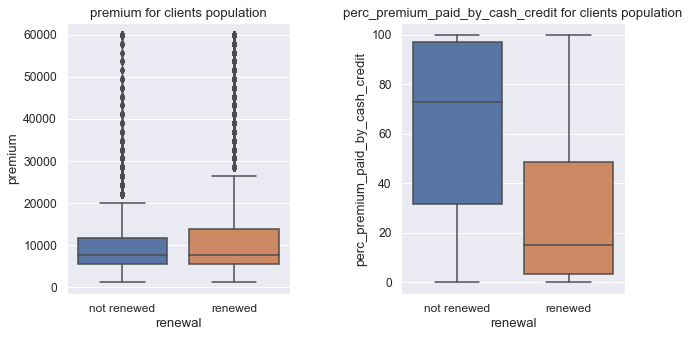

In [25]:
# Write a function: Box-Whisker Plot
def sns_boxplot(x,y,df):
    sns.boxplot(x=x,y=y,data=df)
    lb = [0,1]
    labels = ['not renewed', 'renewed']
    plt.xticks(lb, labels, rotation=0, fontsize=12)
    plt.title(y + ' for clients population')

plt.figure(figsize=(10,5))
# Visualization: categorical and scale 
plt.subplots_adjust(wspace=0.5)
# Box plot: count 6-12 months late
plt.subplot(1,2,1)
sns_boxplot('renewal','premium', df_EDA)

# Box plot: % premium paid by cash/credit
plt.subplot(1,2,2)
sns_boxplot('renewal','perc_premium_paid_by_cash_credit', df_EDA)
plt.show()

** Summary: box plots by the renewal status on premium and % premium paid by cash/credit**
1. Premium: interestingly, the median premium between both populations were same. However, the mean premium was a bit higher in renewed population than not renewed population.  
2. % premium paid by cash/credit: non-renewal population (i.e., 72.8%) had higher median of % premium paid by cash/credit than renewal population (i.e., 14.8%) as expected.

### Uni-variate Analyses: Mean Bar Chart ### 
**By renewal status on numerical features**

In [26]:
# Write a function: groupby 'sourcing_channel' and compute mean numerical features
def df_concat_grp(df1,mu1,df2,mu2,x,y):
    # 1st: groupby 
    df_grp_0 = df1.groupby(x)[y].mean()/mu1
    df_grp_1 = df2.groupby(x)[y].mean()/mu2
    # 2nd: concatenate groupby dataframes
    df_concat_grp = pd.concat([df_grp_0, df_grp_1], axis=1)
    df_concat_grp.columns = ['not renewed','renewed']
    return df_concat_grp

# Write a function to plot:subplots
def grpby_concat_plot(df1,df2,var1,var2):
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    # Subplot 1: feature 1
    df1.plot(kind='bar', ax=ax1, colors=['red','deepskyblue'])
    ax1.set_ylabel('mean ' + var1)
    ax1.set_title('mean ' + var1 + ' by sourcing channel')
    # Subplot 2: feature 1
    df2.plot(kind='bar', ax=ax2, colors=['red','deepskyblue'])
    ax2.set_ylabel('mean ' + var2)
    ax2.set_title('mean ' + var2 + ' by sourcing channel')

C:\Users\yoots\Anaconda3\lib\site-packages\pandas\plotting\_core.py:188: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


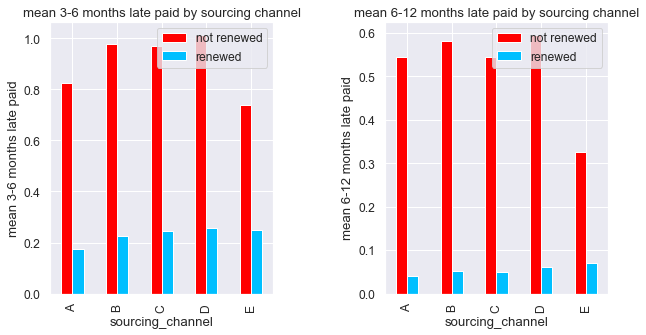

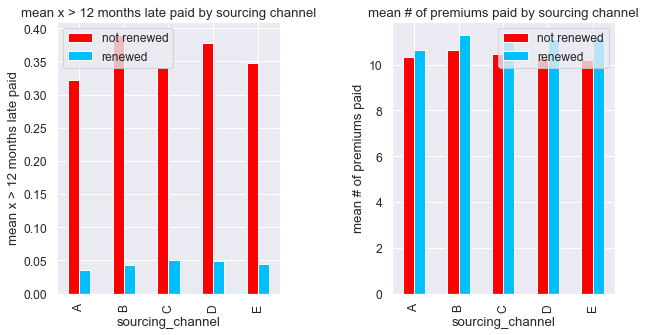

In [27]:
# Groupby and concat dataframes: # of late payments, paid on time
df_concat_grpby_sc_cnt_3_6_mo = df_concat_grp(df_renewal_0,1,df_renewal_1,1,
                                              'sourcing_channel','count_3-6_months_late')
df_concat_grpby_sc_cnt_6_12_mo = df_concat_grp(df_renewal_0,1,df_renewal_1,1,
                                               'sourcing_channel','count_6-12_months_late')
df_concat_grpby_sc_cnt_more_than_12_mo = df_concat_grp(df_renewal_0,1,df_renewal_1,1,
                                               'sourcing_channel','count_more_than_12_months_late')
df_concat_grpby_sc_cnt_premiums_paid = df_concat_grp(df_renewal_0,1,df_renewal_1,1,
                                               'sourcing_channel','no_of_premiums_paid')
# Plot groupby sourcing channel:                                               
# counts: 3-6 months late and 6-12 months late
grpby_concat_plot(df_concat_grpby_sc_cnt_3_6_mo, df_concat_grpby_sc_cnt_6_12_mo,
                  '3-6 months late paid', '6-12 months late paid')
plt.show()

# counts: more than 12 months late, # of premiums paid
grpby_concat_plot(df_concat_grpby_sc_cnt_more_than_12_mo, df_concat_grpby_sc_cnt_premiums_paid,
                  'x > 12 months late paid', '# of premiums paid')
plt.show()

** Summary: mean counts of premiums paid and late payments by a sourcing channel **
1. Mean of late payments: in many cases, any renewal applications from source channel D and followed by B contributed to the higher mean of late payments in comparison to other channels. Also, this held true for both non-renewal and renewed client populations as well.
2. Mean of premiums paid on time: interestingly, there was no huge difference in mean counts of premiums paid between non-renewal and renewed client populations.

C:\Users\yoots\Anaconda3\lib\site-packages\pandas\plotting\_core.py:188: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


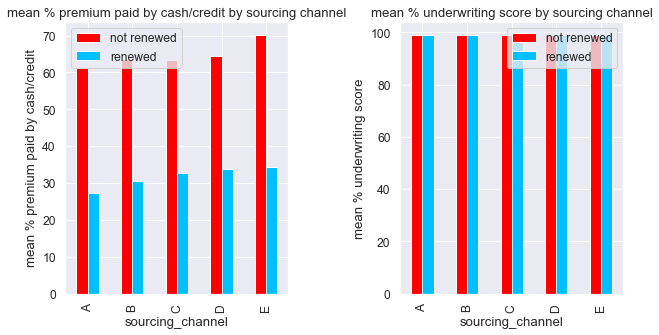

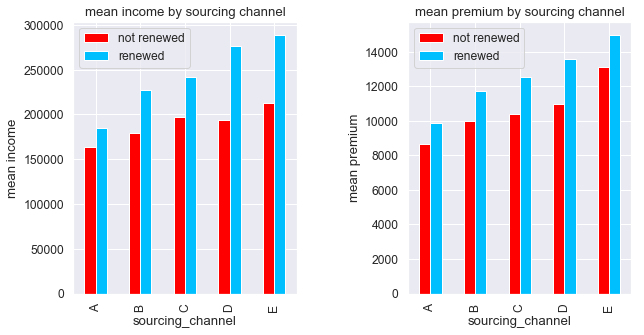

In [28]:
# Groupby and concat dataframes: % and dollar amount ($)
df_concat_grpby_sc_perc_cc = df_concat_grp(df_renewal_0,1,df_renewal_1,1,
                                           'sourcing_channel','perc_premium_paid_by_cash_credit')
df_concat_grpby_sc_app_score = df_concat_grp(df_renewal_0,1,df_renewal_1,1,
                                             'sourcing_channel','application_underwriting_score')
df_concat_grpby_sc_income = df_concat_grp(df_renewal_0,1,df_renewal_1,1,'sourcing_channel','income')
df_concat_grpby_sc_premium = df_concat_grp(df_renewal_0,1,df_renewal_1,1,'sourcing_channel','premium')

# % premium paid by cash/credit, % underwriting score
grpby_concat_plot(df_concat_grpby_sc_perc_cc, df_concat_grpby_sc_app_score,
                  '% premium paid by cash/credit', '% underwriting score')
plt.show()

# income and premium
grpby_concat_plot(df_concat_grpby_sc_income, df_concat_grpby_sc_premium,'income', 'premium')
plt.show()

** Summary: mean of income, premium, % premium paid by cash/credit and application score by a sourcing channel **
1. Mean % premium paid by cash/credit: clients from channel D and E had a higher mean of paying their premiums by cash/credit compared to other channels. Also, the difference in mean % premium paid by cash/credit was roughly around 40% between non-renewal and renewal populations.
2. Mean application score: as is shown above, there was no significant difference in application score by a sourcing channel.
3. Mean income: clients from channel E reported the highest mean income. In contrast, clients from channel A reported the lowest mean income.
4. Mean premium: clients from channel E reported the highest mean premium. In contrast, clients from channel A reported the lowest mean premium.

### Bi-variate Analyses: Multi-Faceted Scatter Plots ###

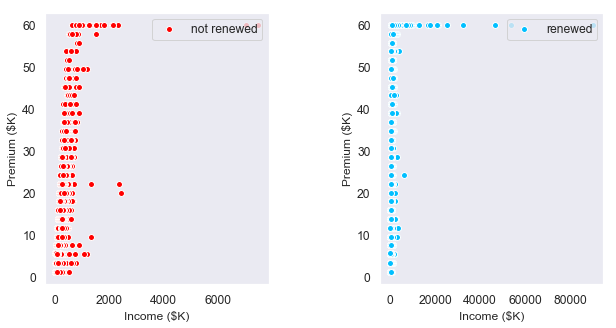

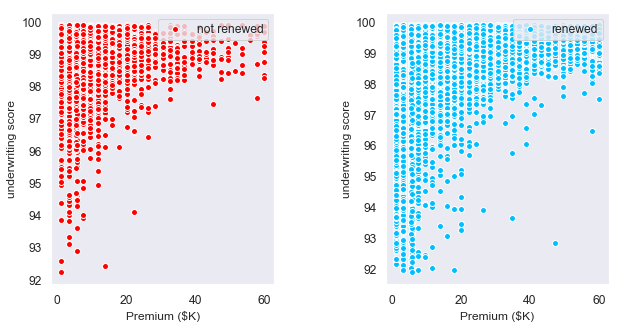

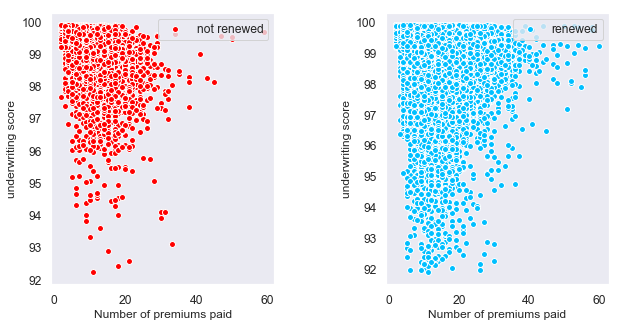

In [29]:
# Write a function: multi-faceted scatter plots by renewal status
def multi_sct_plot(x,xlab,n_x,y,ylab,n_y):
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    # Subplot 1: non-renewal 
    ax1.scatter(df_renewal_0[x]/n_x,df_renewal_0[y]/n_y,label='not renewed',
                color='red',edgecolor='w')
    ax1.legend(loc='upper right')
    ax1.set_xlabel(xlab, fontsize=12)
    ax1.set_ylabel(ylab, fontsize=12)
    ax1.grid(False)

    # Subplot 2: renewal
    ax2.scatter(df_renewal_1[x]/n_x,df_renewal_1[y]/n_y,label='renewed',
                color='deepskyblue',edgecolor='w')    
    ax2.legend(loc='upper right')
    ax2.set_xlabel(xlab, fontsize=12)
    ax2.set_ylabel(ylab, fontsize=12)
    ax2.grid(False)

# Faceted scatter plot: income vs. premium 
multi_sct_plot('income','Income ($K)',1000,
               'premium','Premium ($K)',1000)
plt.show()

# Faceted scatter plot: no premiums paid vs. underwriting_score
multi_sct_plot('premium','Premium ($K)',1000,
               'application_underwriting_score','underwriting score',1)
plt.show()

# Faceted scatter plot: no premiums paid vs. underwriting_score
multi_sct_plot('no_of_premiums_paid','Number of premiums paid',1,
               'application_underwriting_score','underwriting score',1)
plt.show()

** Summary: a pair of faceted scatter plots by the renewal status **
1. income vs. premium: in general, clients with higher income tend to be paying higher premiums in both populations.
2. premium vs. underwriting score: clients with higher premium showed higher underwriting score in both populations. However, the scatter plot didn't seem to show a clear trend as it showed the quite wide distribution of points. 
3. no. of premiums paid vs. underwriting score: expected to see a trend where clients with higher # of premiums paid on time with higher underwriting score. However, the distribution of scatter plots in both the non-renewal and renewal population were not that clear.

## Part C. Machine Learning Modeling: Classification ##

### Dummy Variable Encoding: nominal features ###
Dummy variable encoding is a process in which it converts categorical (i.e., ordinal/nominal) features into dummy features in which values are encoded as '0' or '1' only. These dummy features get interpreted by machine learning models for making better predictions. Also, we must ensure dropping each feature's first encoded dummy variable to avoid the dummy variable trap. This step ensures that we don't have any converted independent dummy variables that are highly inter-correlated with each other. Thus, we reduce any potential biases of having multi-collinearity upon making predictions on a test set.

In [30]:
# Copy dataframe for machine learning:
df_ML = df_EDA.copy()
# Drop generated features:
df_ML = df_ML.drop(['age_group','count_3-6_mo_group','count_6-12_mo_group',
'count_more_than_12_mo_group','no_premiums_paid_group','premium_group','income_group'],axis=1)
# Re-initialize index starts from zero:
#df_ML.reset_index(drop=True)

# Dummy Variable Encoding: nominal features #
###############################################################################
# Drop first dummy variable on each nominal feature to avoid dummy variable trap:
df_transformed = pd.get_dummies(df_ML.drop(['renewal'], axis=1),drop_first=True)

# Concatenate dummy variable encoded dataframe and admit (output) label together:
df_transformed = pd.concat([df_transformed, df_ML['renewal']], axis=1)

# Print top & bottom 5 observations:
print(df_transformed['renewal'].value_counts())

# Check dataframe info.:
df_transformed.info()

1    74855
0     4998
Name: renewal, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79853 entries, 0 to 79852
Data columns (total 16 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_years                        79853 non-null float64
income                              79853 non-null int64
count_3-6_months_late               79853 non-null float64
count_6-12_months_late              79853 non-null float64
count_more_than_12_months_late      79853 non-null float64
application_underwriting_score      79853 non-null float64
no_of_premiums_paid                 79853 non-null int64
premium                             79853 non-null int64
sourcing_channel_B                  79853 non-null uint8
sourcing_channel_C                  79853 non-null uint8
sourcing_channel_D                  79853 non-null uint8
sourcing_channel_E                  79853 non-null uint8
residence_area_type_Urban      

### Split on input features and output label ###
For insurance propensity problem, the following set of classifiers were tested which included logistic regression, decision tree, random forest, gradient boosting (XGBoost) and majority vote (ensemble) classifier.

After completion of modeling, RandomizedSearchCV module was applied to further optimize and tune hyperparameters (i.e., C, n_estimators, etc.) on each model. These optimized models help us to achieve finding the best model with the highest accuracy and AUC-ROC scores.

In [31]:
##########################################
# QA check on input features/class label #
# Re-define input features and output label:
X, y = df_transformed.iloc[:,:-1].values, df_transformed.iloc[:, -1].values
# Print unique labels for ED admission:
print('class labels:', np.unique(y))

class labels: [0 1]


### Data Partition & Feature Scaling ###
* First, we applied the data partition step. This process splits the original data into training and test sets for model training/validation and evaluation of any machine learning modeling tasks. Here, we allocated 75% of data into train and 25% of data into test sets.

* Second, we applied the feature scaling step. This process intakes any input features with different ranges of scale then feed into a scalar function (i.e., min-max, logarithmic, etc.). This re-scale all input features to end up with a similar range of scale on each feature. This is extremely crucial for any classification algorithm with a distance-based approach which impacts on the accuracy of model predictions as well.

In [32]:
###############################################################################
# General: data parition - train vs. test set
# Use built-in stratify mode to ensure equal % label splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, 
                                                    random_state=0, stratify=y)
# Check label counts on the split set:
print('class label counts in total:', np.bincount(y))
print('class label counts in train set:', np.bincount(y_train))
print('class label counts in test set:', np.bincount(y_test))

# Feature Scaling: 
sc_X = StandardScaler()
X_train_std = sc_X.fit_transform(X_train[:,1:])
X_test_std = sc_X.fit_transform(X_test[:,1:])

class label counts in total: [ 4998 74855]
class label counts in train set: [ 3748 56141]
class label counts in test set: [ 1250 18714]


### Feature Selection: using Feature Importance & Recursive Elimination ###
* Feature importance module is available on Decision Tree, Random Forest, and XGB classifiers
* For Logistic Regression classifier, a recursive elimination approach was used here since it is not equipped with feature importance module.

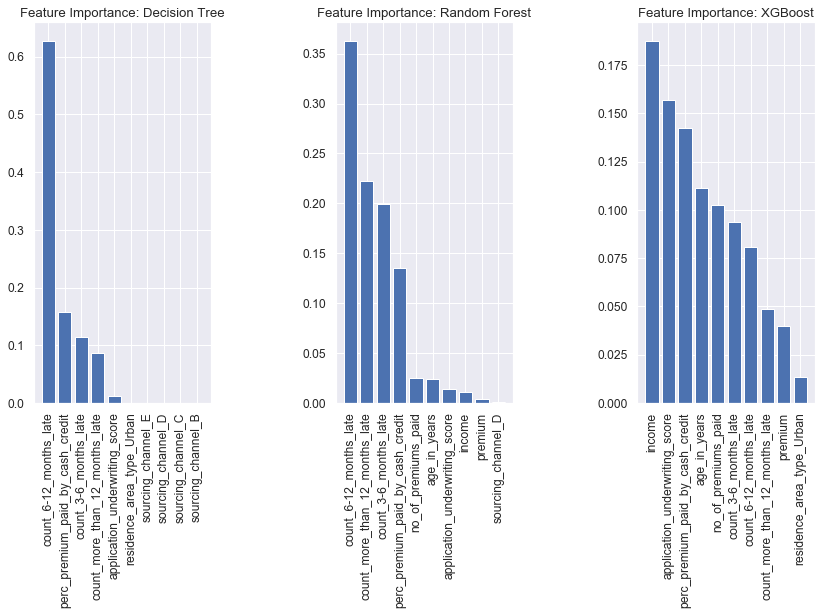

Num Features: 2
Selected Features: [ True False False  True False False False False False False False False
 False False]
Feature Ranking: [ 1  4  6  1  2  3  5  7 10 12  9  8 13 11]


In [33]:
# Write a function F.I.P plot: Top 10 features
def fip_plot(model):
    model = model
    model.fit(X_train_std, y_train)
    feat_labels = df_transformed.columns[1:-1]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][0:10]
    # Plot bar chart:
    plt.bar(range(10), importances[indices], align='center')
    plt.xticks(range(10), feat_labels[indices], rotation=90)

plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.7)

# Feature Selection: Feature Importance #
# Plot: decision tree
plt.subplot(1,3,1)
plt.title('Feature Importance: Decision Tree')
fip_plot(DecisionTreeClassifier(criterion='gini', 
                                max_depth=4, random_state=0))

# Plot: random forest
plt.subplot(1,3,2)
plt.title('Feature Importance: Random Forest')
fip_plot(RandomForestClassifier(criterion='gini', n_estimators=25,
                                max_depth=4, random_state=0))

# Plot: xgboost
plt.subplot(1,3,3)
plt.title('Feature Importance: XGBoost')
fip_plot(XGBClassifier(n_estimators=100, n_jobs=1, 
                                learning_rate=0.2, random_state=0))
plt.show()

# Feature Selection: Recursive Feature Elimination #
lr = LogisticRegression(random_state=0)
from sklearn.feature_selection import RFE
rfe = RFE(lr,2)
rfe.fit(X_train_std, y_train)
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

**Summary: feature selection by different ML algorithms **

In general, there was a bit of difference in feature importance ranked by different algorithms. However, the common important selected features were % premium paid by cash/credit, count 3-6 months late, count 6-12 months late etc.

### Decision Boundary: ML Classifications ###
Here, I plotted a decision boundary classification plot for the top two selected features on each algorithm. The main idea behind these plots to show us how well non-renewed vs. renewed clients can be separated by which combination of features.

In [34]:
# Write a function: model fitting and predictions
def ml_fit_boundary(model, input_range):
    # Input feature selections:
    X_train_ml, X_test_ml = X_train_std[:, input_range], X_test_std[:, input_range]
    # Fit model:
    model = model
    model.fit(X_train_ml, y_train)
    return X_test_ml, model
    
# Retrieve a trained model and test set input features:
##########################
# 1. Logistic Regression #
##########################
X_test_lr, lr = ml_fit_boundary(LogisticRegression(C=0.1,penalty='l1',random_state=0), [0,4])
##########################
# 2. Decision Tree #
##########################
X_test_dt, tree = ml_fit_boundary(DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,random_state=0), [0,3])

##########################
# 3. Random Forest #
##########################
X_test_rf, forest = ml_fit_boundary(RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,n_jobs=1,random_state=0,), [0,3])

##########################
# 4. XGBoost #
##########################
X_test_xgb, xgb = ml_fit_boundary(XGBClassifier(learning_rate=0.2, n_estimators=50,
                       max_depth=1,n_jobs=1,random_state=0), [2,6])

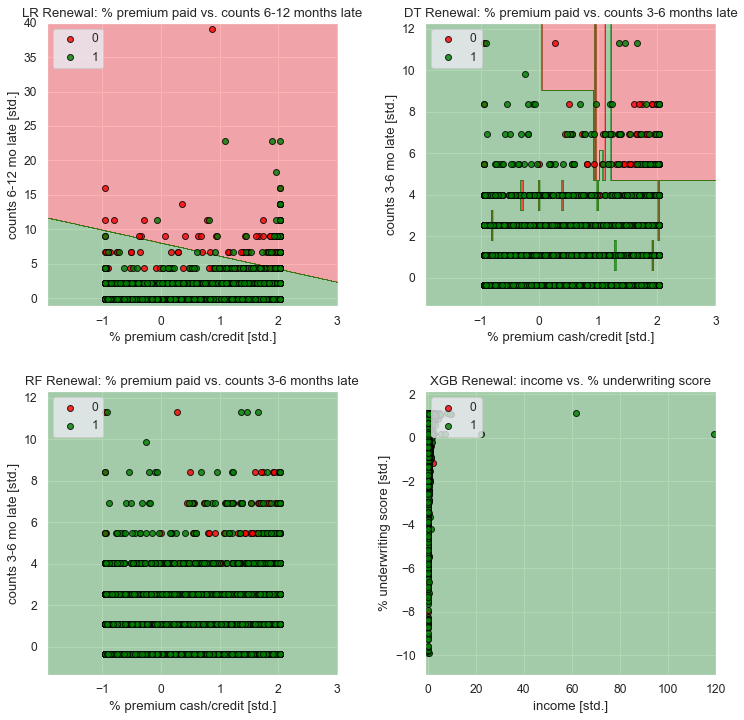

In [35]:
# Write a function: plot decision boundary regions
def decision_boundary_plt(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and colormap
    markers = ('o','o','s','^','v')
    colors = ('red','green','blue','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot: decision surface
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Plot: scatter plot
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')
        
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#################################################################################
# Visualize renewal classification: LR
plt.subplot(2,2,1)
decision_boundary_plt(X=X_test_lr, y=y_test, classifier=lr)
plt.title('LR Renewal: % premium paid vs. counts 6-12 months late')
plt.xlabel('% premium cash/credit [std.]')
plt.ylabel('counts 6-12 mo late [std.]')
plt.legend(loc='upper left')

# Visualize renewal classification: DT
plt.subplot(2,2,2)
decision_boundary_plt(X=X_test_dt, y=y_test, classifier=tree)
plt.title('DT Renewal: % premium paid vs. counts 3-6 months late')
plt.xlabel('% premium cash/credit [std.]')
plt.ylabel('counts 3-6 mo late [std.]')
plt.legend(loc='upper left')

# Visualize renewal classification: RF
plt.subplot(2,2,3)
decision_boundary_plt(X=X_test_rf, y=y_test, classifier=forest)
plt.title('RF Renewal: % premium paid vs. counts 3-6 months late')
plt.xlabel('% premium cash/credit [std.]')
plt.ylabel('counts 3-6 mo late [std.]')
plt.legend(loc='upper left')

# Visualize renewal classification: XGB
plt.subplot(2,2,4)
decision_boundary_plt(X=X_test_xgb, y=y_test, classifier=xgb)
plt.title('XGB Renewal: income vs. % underwriting score')
plt.xlabel('income [std.]')
plt.ylabel('% underwriting score [std.]')
plt.legend(loc='upper left')
#################################################################################
plt.show()

### K-fold Cross Validation ###
Now, after data partition, we wanted to assess the predictive performance of the models and gauge how they perform outside the training set to unseen dataset also known as a test set. To do that, I used the stratified k-fold cross-validation. Basically, the training set from the first data partition divided into multiple folds of data. For every iteration, one-fold became a validation fold and other remaining became training folds to train a model. Thus, this whole procedure will be repeated "k" times which often equals the number of folds and a validation fold will be-be switched between each iteration. Finally, the model performance over training folds will be evaluated by averaging performances across all iterations.

In [36]:
# Testing: let's define top common useful input features:
X_cm, y_cm = X_train_std, y_train
#X_cm, y_cm = X_train_std[:,[0,1,2,3,4,5,6,7,10]], y_train

# Stratified: K-fold Cross-validation
skf = StratifiedKFold(n_splits=5, random_state=0)
for train_idx, val_idx in skf.split(X_cm, y_cm):
    X_train_cm, X_val_cm = X_cm[train_idx], X_cm[val_idx]
    y_train_cm, y_val_cm = y_cm[train_idx], y_cm[val_idx]

# Define hold-out test set: 
X_test_cm = X_test_std
#X_test_cm = X_test_std[:,[0,1,2,3,4,5,6,7,10]]

### Model Evaluation: Feature Selection ###
Compute a normalized confusion matrix and classification metrics on following models:
* Logistic Regression
* Decision Tree
* Random Forest
* XGBoost

### Model 1: Logistic Regression ###
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1]. For example, if P(1=renewed) ≥ 0.5, an observation is predicted as a renewed. Whereas if P(1=renewed) < 0.5, an observation is predicted as a not renewed.

In [37]:
# Model: Logistic Regression
lr_cv = LogisticRegression(C=0.1,penalty='l1',random_state=0)
lr_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: LogisticRegression #
# Create hyperparameter options:
param_dist = dict(C=randint(2,100), penalty=['l1','l2'])
random_search_lr = RandomizedSearchCV(estimator=lr_cv, param_distributions=param_dist,
                                   random_state=0, n_iter=100, cv=5)
random_search_lr = random_search_lr.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best Penalty:', random_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', random_search_lr.best_estimator_.get_params()['C'])

# Model prediction: test set
y_pred_test_lr = random_search_lr.predict(X_test_cm)   

# Model predition probabilities: test set
y_pred_prob_test_lr = random_search_lr.predict_proba(X_test_cm)[:,1]    

Best Penalty: l2
Best C: 46


### Model 2: Decision Tree ###
A decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. A tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to the same class as either not renewed or renewed cases only).

In [38]:
# Model: DecisionTree [cross-validated & std. train set]
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_dt = {"criterion": ["gini", "entropy"],
                  "max_depth": randint(1, 50),
                  "max_leaf_nodes": randint(10, 20),
                  "min_samples_split": randint(2, 100),
                  "min_samples_leaf": randint(2, 30)}
random_search_dt = RandomizedSearchCV(estimator=tree_cv, param_distributions=param_dist_dt,
                                   random_state=0, n_iter=300, scoring='roc_auc', cv=5)
random_search_dt = random_search_dt.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])

# Model prediction: test set
y_pred_test_dt = random_search_dt.predict(X_test_cm)  

# Model predition probabilities: test set
y_pred_prob_test_dt = random_search_dt.predict_proba(X_test_cm)[:,1]    

Best min_samples_split: 13
Best min_samples_leaf: 25
Best max_depth: 36


### Model 3: Random Forest ###
Random forest is a typical ensemble learning model. It takes a random subsample of data from each tree, so all constructed trees are different from each other. Thus, the model makes a classification based on predictions made from each tree with averaging (i.e., like a voting from majority wins).

In [39]:
# Model: RandomForest [cross-validated & std. train set]
forest_cv = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_rf = {"n_estimators": randint(10, 55), 
                 "max_depth": randint(1, 10),
                  "min_samples_split": randint(2, 120),
                  "min_samples_leaf": randint(2, 20),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
random_search_rf = RandomizedSearchCV(estimator=forest_cv, param_distributions=param_dist_rf,
                                   random_state=0, scoring='roc_auc', cv=5)
random_search_rf = random_search_rf.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

# Model prediction: test set
y_pred_test_rf = random_search_rf.predict(X_test_cm)

# Model predition probabilities: test set
y_pred_prob_test_rf = random_search_rf.predict_proba(X_test_cm)[:,1]    

Best n_estimators: 52
Best max_depth: 6
Best min_samples_split: 107
Best min_samples_leaf: 19


### Model 4: XGBoost ###
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of the previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how the XGBoost model to improve performances.

In [40]:
# Model: XGBClassifier [cross-validated & std. train set]
xgb_cv = XGBClassifier(n_estimators=50, learning_rate=0.2,
                       max_depth=1, random_state=0, n_jobs=1)
xgb_cv.fit(X_train_cm, y_train_cm)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_xgb = {"n_estimators": randint(10, 300), 
                 "max_depth": randint(2, 15),
                  "learning_rate": np.random.uniform(0,1,10),
                  "objective": ['binary:logistic','reg:linear'],
                  "booster": ['gbtree','gblinear']}
random_search_xgb = RandomizedSearchCV(estimator=xgb_cv, param_distributions=param_dist_xgb,
                                   random_state=0, scoring='roc_auc', cv=5)
random_search_xgb = random_search_xgb.fit(X_val_cm, y_val_cm)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])
print('Best booster:', random_search_xgb.best_estimator_.get_params()['booster'])

# Model prediction: test set
y_pred_test_xgb = random_search_xgb.predict(X_test_cm)

# Model predition probabilities: test set
y_pred_prob_test_xgb = random_search_xgb.predict_proba(X_test_cm)[:,1]    

Best n_estimators: 287
Best max_depth: 11
Best learning_rate: 0.562181008427
Best objective: binary:logistic
Best booster: gblinear


## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table which used to describe the classifier's model performance on a test set, for which the true values (i.e., true renewed and true not renewed cases) are known.
1. True Positives (TP): model predicted yes, and they renewed the policy.
2. True Negatives (TN): model predicted no, and they don't renew the policy.
3. False Positives (FP): model predicted yes, but they don't renew the policy. (Also known as a "Type I error.")
4. False Negatives (FN): model predicted no, but they renewed the policy. (Also known as a "Type II error.")

In [41]:
# Making the Confusion/Contingency Matrix #
###############################################################################
# Write a function: plot_confusion_matrix #
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots(figsize=(5,5))
    cm = cm.astype('float') / cm.sum()
#   cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')    
        
    #plt.tight_layout()
    plt.xlabel('predicted label')
    plt.ylabel('true label')

# Make class labels for "stroke"
class_labels = np.array(['not renewed','renewed'], dtype=str)        

# Write a function: report classification metrics
###############################################################################
def rep_class_metrics(y_act, y_pred, model_name):
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_act, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_act, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_act, y_pred))

# Write a function: report roc_auc score
def rep_roc_auc_score(y_act, y_pred_prob, model_name):
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_act, y_pred_prob))

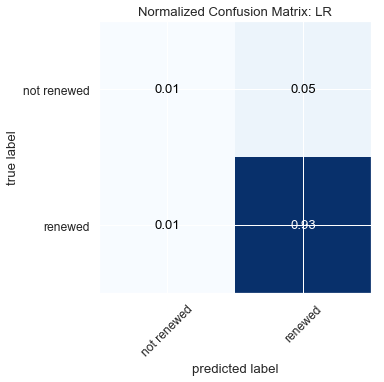

Accuracy of LR Test is 0.94
Precision of LR Test is 0.94
Recall of LR Test is 0.99
ROC score of LR Test is 0.82


In [42]:
# Plot confusion matrix on test set: Logistic Regression
###############################################################################
cm_test_lr = skm.confusion_matrix(y_test, y_pred_test_lr)
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_lr, class_labels)
plt.title('Normalized Confusion Matrix: LR')
plt.show()

# Classification metrics on train set and test set: LogisticRegression
rep_class_metrics(y_test, y_pred_test_lr, 'LR Test')
rep_roc_auc_score(y_test, y_pred_prob_test_lr, 'LR Test')

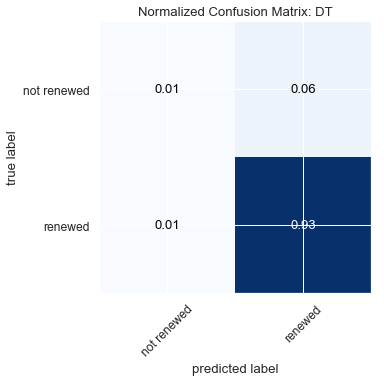

Accuracy of DT Test is 0.94
Precision of DT Test is 0.94
Recall of DT Test is 0.99
ROC score of DT Test is 0.82


In [43]:
# Plot confusion matrix on test set: DecisionTree
###############################################################################
cm_test_dt = skm.confusion_matrix(y_test, y_pred_test_dt)  
np.set_printoptions(precision=3)  

plot_confusion_matrix(cm_test_dt, class_labels)
plt.title('Normalized Confusion Matrix: DT')
plt.show()

# Classification metrics on train set and test set: DecisionTree
rep_class_metrics(y_test, y_pred_test_dt, 'DT Test')
rep_roc_auc_score(y_test, y_pred_prob_test_dt, 'DT Test')

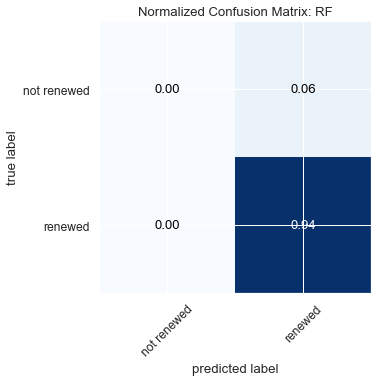

Accuracy of RF Test is 0.94
Precision of RF Test is 0.94
Recall of RF Test is 1.00
ROC score of RF Test is 0.83


In [44]:
# Plot confusion matrix on test set: RandomForest
###############################################################################
cm_test_rf = skm.confusion_matrix(y_test, y_pred_test_rf)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_rf, class_labels)
plt.title('Normalized Confusion Matrix: RF')
plt.show()

# Classification metrics on train set and test set: RandomForest
rep_class_metrics(y_test, y_pred_test_rf, 'RF Test')
rep_roc_auc_score(y_test, y_pred_prob_test_rf, 'RF Test')

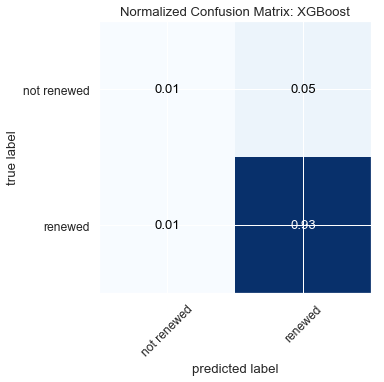

Accuracy of XGB Test is 0.94
Precision of XGB Test is 0.94
Recall of XGB Test is 0.99
ROC score of XGB Test is 0.82


In [45]:
# Plot confusion matrix on test set: XGBoost
###############################################################################
cm_test_xgb = skm.confusion_matrix(y_test, y_pred_test_xgb) 
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Classification metrics on train set and test set: XGBoost
rep_class_metrics(y_test, y_pred_test_xgb, 'XGB Test')
rep_roc_auc_score(y_test, y_pred_prob_test_xgb, 'XGB Test')

**Summary: confusion matrix for 5 different classification algorithms**

In terms of precision and recall, all ensemble models (i.e., Random Forest, XGBoost) had the highest performances. Also, this holds true with respect to the AUC-ROC score of 83% as well. With regards to accuracy, Random Forest outperformed the XGBoost model by 1% because the RF predicted 94% of renewed clients whereas the XGB predicted 93% of renewed clients.

### Model Evaluation: precision-recall curve ###
Precision-Recall is a useful measure of success for predictions when the classes of the dataset are highly imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall at different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning most of all positive results (high recall).

In summary, a system with high recall but low precision returns many predictions where most of the prediction results are incorrect when compared to actual true labels. Conversely, a system with low recall and high precision returns: few predictions but most of its prediction results are correct when compared to actual true labels.

Average precision-recall score of RandomForest model: 0.98


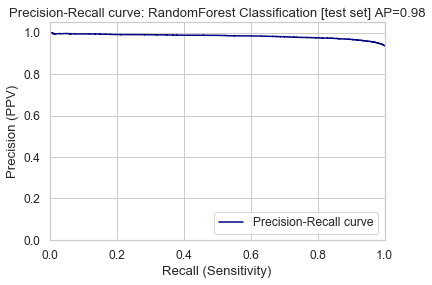

In [46]:
############################################
# Model Evaluation: Precision Recall Curve #
############################################
# Compute average precision score:
###############################################################################
y_score_rf = random_search_rf.predict_proba(X_test_cm)[:,1]
avg_precision = skm.average_precision_score(y_test, y_score_rf)

print('Average precision-recall score of RandomForest model: {0:0.2f}'.format(
      avg_precision))

# Plot Precision-Recall curve:
###############################################################################
precision, recall, _ = skm.precision_recall_curve(y_test, y_score_rf)

sns.set_style('whitegrid')

plt.step(recall, precision, color='navy', where='post',label='Precision-Recall curve')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='navy')
plt.title('Precision-Recall curve: RandomForest Classification [test set] AP={0:0.2f}'
          .format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

**Summary: Precision-Recall curve for the best classification model**

Overall, the majority vote classifier showed the best weighted average precision of 0.98. In other words, 98% of the time a model is good at making insurance policy renewal predictions from total # of actual renewed cases.

### Model Evaluation: ROC curve ###
ROC curve typically displays true positive rate on the Y-axis, and false positive rate on the X-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important since it is ideal to maximize the true positive rate while minimizing the false positive rate.

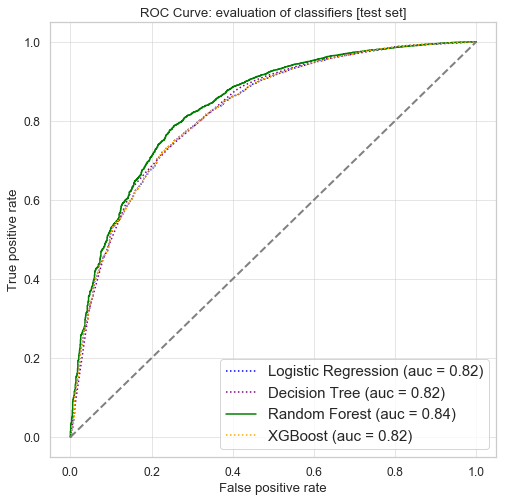

In [47]:
# Classifiers Label: #
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
all_clf = [random_search_lr, random_search_dt, random_search_rf, random_search_xgb]

###################################
# Model Evaluation: ROC-AUC Curve #
###################################
# Plot a ROC Curve #
plt.figure(figsize=(8,8))
# ROC for each classifiers
colors = ['blue', 'purple', 'green', 'orange']
linestyles = [':', ':', '-', ':']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
        # Asumming the label of the positive class is 1
        y_pred = clf.fit(X_train_cm,
                         y_train_cm).predict_proba(X_test_cm)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_test,
                                         y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (auc = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1],linestyle='--',color='gray',linewidth=2)    
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: evaluation of classifiers [test set]')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

**Summary: ROC curve for 5 different classification algorithms**

Overall, the top 5 classifiers showed a mean AUC of 0.83. In summary, about 84% of the time the Random Forest classifier was good at separating 'not renewed client' predictions from 'renewed client' predictions.

### Final Model Predictions and Calculate Total Net Revenue ###
First, there are three pieces of information that we must account for calculating the total net revenue. Note that insurance company has used sophisticated psychological research to arrive at these relationships and we can assume them to be true for our purpose of building an incentive plan.

**Relationship 1: incentives (I) vs. effort (t)**
* This relationship can be described by the following equation: where 't' stands for the effort of hours invested by an agent and 'I' stands for incentives given to an agent. After a certain saturation point, the providing more incentives do not convert into the extra effort of hours (t). 
* t = 10 X (1-exp(-I/400)) --> I = -400 X np.log(1-t/10);

**Relationship 2: effort (t) vs. improvement in renewal probability (p_imp)**
* This relationship can be described by the following equation: where 't' stands for the effort of hours invested by an agent and 'p_imp' stands for % improvement in renewal probability. After a certain saturation point, the investing more hours do not convert into % improvement in renewal probability (p_imp). 
* p_imp = 20 X (1-exp(-t/5))

**Equation: calculating the total net revenue generated from each policy renewal**
* total_net_rev = np.sum(p_benchmark X premium X (1+p_imp)-incentive), where p_benchmark stands for the renewal probability, p_imp stands for % improvement in renewal probability, 'premium' stands for amount of premium collected from each policy and finally 'incentive' stands for amount of incentive given to an agent.

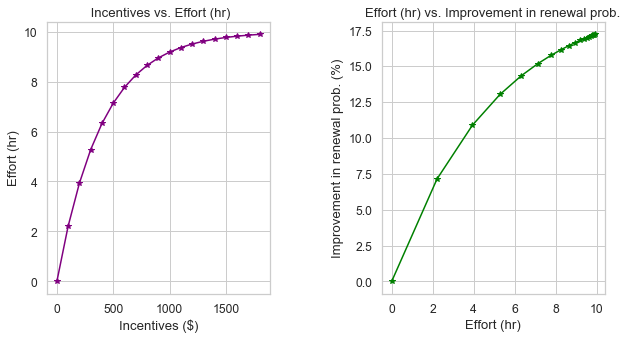

In [48]:
######################################################################
# Plot two relationships given by the insurance company 
######################################################################
# 1a. Incentives ($) vs. Effort (hour) #
########################################
I1 = np.arange(0,1900,100)
t1 = 10*(1-np.exp(-I1/400))

# Make a dataframe for incentives plan:
df_time = pd.DataFrame({'incentives':I1, 'time':t1})

# 2. Effort (hour) vs % improvement in renewal prob. #
######################################################
t = t1;
p_improvement = 20*(1-np.exp(-t/5))/100

# Make a dataframe for improvement in renewal prob.:
df_renewal_imp = pd.DataFrame({'time':t, 'p_improvement':p_improvement})

# Plot two relationships in each subplot:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Subplot 1: incentive vs. effort
ax1.plot(df_time['incentives'], df_time['time'],
        c='purple', marker='*')
ax1.set_title(' Incentives vs. Effort (hr)')
ax1.set_xlabel('Incentives ($)')
ax1.set_ylabel('Effort (hr)')
# Subplot 2: effort vs. % improvement in renewal prob.
ax2.plot(df_renewal_imp['time'], df_renewal_imp['p_improvement']*100,
        c='green', marker='*')
ax2.set_title('Effort (hr) vs. Improvement in renewal prob.')
ax2.set_xlabel('Effort (hr)')
ax2.set_ylabel('Improvement in renewal prob. (%)')
plt.show()

In [49]:
######################################################################
# Compute: % improvement in renewal prob, incentives and net revenue #
######################################################################
# Use the best model to predict on hold-out test set:
y_pred_best = y_pred_test_rf # predictions
y_pred_prob_best = y_pred_prob_test_rf # prediction probabilities 

# Prepare basic metrics: p_benchmark, incentive:
#p_imp = ((1-p_benchmark)/p_benchmark)/100 # p_imp (% improvement prob. of renewal)
i_range = np.arange(0,1840,0.0921659) # calculated the range of incentives;
incentive = np.random.permutation(i_range) # random permuation of incentives;
p_benchmark = y_pred_prob_best.copy() # (% prob. of renewal)
premium = X_test[:,9]

# Write a group of function #
#############################
# Function 1: incentives to effort
def incentive_to_t(I):
    return 10*(1-np.exp(-I/400))

# Function 2: efforts to p_imp 
def t_to_p_imp(t):
    return 20*(1-np.exp(-t/5))

# Function 3: calculate total net revenue
def net_revenue(p_benchmark, premium, p_imp, incentive):
    return (p_benchmark*premium*(1+p_imp)-incentive)

# Final model KPI metrics:
t = incentive_to_t(incentive) # calculated efforts invested by an agent
p_imp = t_to_p_imp(t) # calculated % improvement in prob. of renewal
net_rev = net_revenue(p_benchmark, premium, p_imp, incentive) # calculated net revenue on each policy

# Final output:
output = np.hstack((X_test[:,0].reshape(-1,1), p_benchmark.reshape(-1,1), incentive.reshape(-1,1)))
output = pd.DataFrame(output)
output.columns = ['id','p_benchmark','incentive']

# Print output head and total net revenue:
print(output.head())
print(output.tail())
print('Estimated total_net_revenue ' + ' is %0.0f'% np.sum(net_rev))

# Save output for ML submission: id, p_benchmark, incentive
output.to_csv('IP_renewal_imbalanced_MV.csv')

         id  p_benchmark    incentive
0  105569.0     0.972566   304.147470
1   25903.0     0.984143  1336.129052
2   27444.0     0.965814  1526.175138
3  112151.0     0.965368   764.055311
4   51468.0     0.986703  1796.313391
            id  p_benchmark    incentive
19959  73794.0     0.983153   419.539177
19960  95108.0     0.986617  1267.926286
19961  84980.0     0.978548   173.732721
19962  22402.0     0.772195   170.783413
19963  26666.0     0.907728  1249.953936
Estimated total_net_revenue  is 3308684559
